In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()

'/home/azureuser/localfiles/capalloc/notebooks'

In [28]:
paths = {}
# paths["keep_maximum_smartly"] = "../results/2024_11_21/21_8_0/"
paths["immediate"] = "../results/2024_12_3/8_14_32/"
# paths["delay_changes"] = "../results/2024_11_21/22_3_36/"
# paths["keep_maximum_instances"] = "../results/2024_11_21/22_30_19/"
# paths["keep_minimum_instances"] = "../results/2024_11_21/22_54_36/"
paths["short_term_scaler"] = "../results/2024_12_2/20_9_36/"

In [29]:
df_request_logs = {}
for strategy in paths.keys():
    dfs = []
    for region in ["centralus", "eastus", "westus"]:
        for i in range(28):
            dfs.append(pd.read_csv(f"{paths[strategy]}/region_routers/{region}/{i}.csv"))
            dfs[-1]["region"] = region
    df_request_logs[strategy] = pd.concat(dfs)

In [30]:
df_request_logs["immediate"].head()

,request_id,model,workload_type,arrival_timestamp,completion_timestamp,global_router_queue_time,region_router_queue_time,model_endpoint_router_queue_time,application_scheduler_queue_time,service_time,application_scheduler_response_time,model_endpoint_router_response_time,region_router_response_time,global_router_response_time,queue_time,region
0,6899997,D,prod,0.157615,0.0,1.0,1.000000e-07,1.000000e-07,0.0,0.985302,0.985302,0.985302,0.985302,0.0,1.000000,centralus
1,6899996,D,prod,0.162606,0.0,1.0,1.000000e-07,1.000000e-07,0.0,1.017402,1.017402,1.017402,1.017402,0.0,1.000000,centralus
2,5099998,C,prod,1.471764,0.0,1.0,1.000000e-07,1.000000e-07,0.0,0.119330,0.119330,0.119330,0.119331,0.0,1.000000,centralus
3,6899992,D,prod,0.611222,0.0,1.0,1.000000e-07,1.000000e-07,0.0,1.024412,1.024412,1.024412,1.024412,0.0,1.006824,centralus
4,6899988,D,prod,1.255485,0.0,1.0,1.000000e-07,1.000000e-07,0.0,0.948515,0.948515,0.948515,0.948515,0.0,1.005395,centralus


In [31]:
for strategy in df_request_logs.keys():
    df = df_request_logs[strategy]
    print(strategy)
    print("\t", len(df))
    print("\t", df.loc[df["workload_type"] == "prod"]["region"].value_counts())

immediate
	 1428165
	 region
eastus       601916
centralus    416198
westus       393141
Name: count, dtype: int64
short_term_scaler
	 1467745
	 region
eastus       623080
centralus    421661
westus       404982
Name: count, dtype: int64


In [32]:
df_instance_counts = {}
for strategy in paths.keys():
    dfs = []
    for region in ["centralus", "eastus", "westus"]:
        for i in range(28):
            dfs.append(pd.read_csv(f"{paths[strategy]}/arbiters/{region}/{i}.csv"))
            dfs[-1]["region"] = region
    df_instance_counts[strategy] = pd.concat(dfs)
# df_instance_counts["immediate"] = pd.read_csv(f"{paths['immediate']}/global_ariber_logs.csv")

In [33]:
df_instance_counts["immediate"]

,timestamp,model,prod,spot,region
0,0.000000,A,39,1,centralus
1,0.000000,B,40,0,centralus
2,0.000000,C,40,0,centralus
3,0.000000,D,40,0,centralus
4,0.000000,A,38,2,centralus
...,...,...,...,...,...
7,97201.358452,D,2,38,westus
8,97201.358452,A,2,38,westus
9,97201.358452,B,2,38,westus
10,97201.358452,C,2,38,westus


In [34]:
df_instance_counts["immediate"].loc[df_instance_counts["immediate"]["model"]=="B"].groupby(by=["timestamp"])["prod"].agg([("max", "max"), ("min", "min"), ("cnt", "count")]).reset_index()

,timestamp,max,min,cnt
0,0.000000,40,2,468
1,3600.137269,2,2,11
2,7200.167587,2,2,9
3,10800.245850,2,2,10
4,14400.321754,2,2,9
5,18000.410764,2,2,9
6,21600.443370,2,2,9
7,25200.451985,2,2,9
8,28800.636990,2,2,9
9,32400.672060,2,2,9


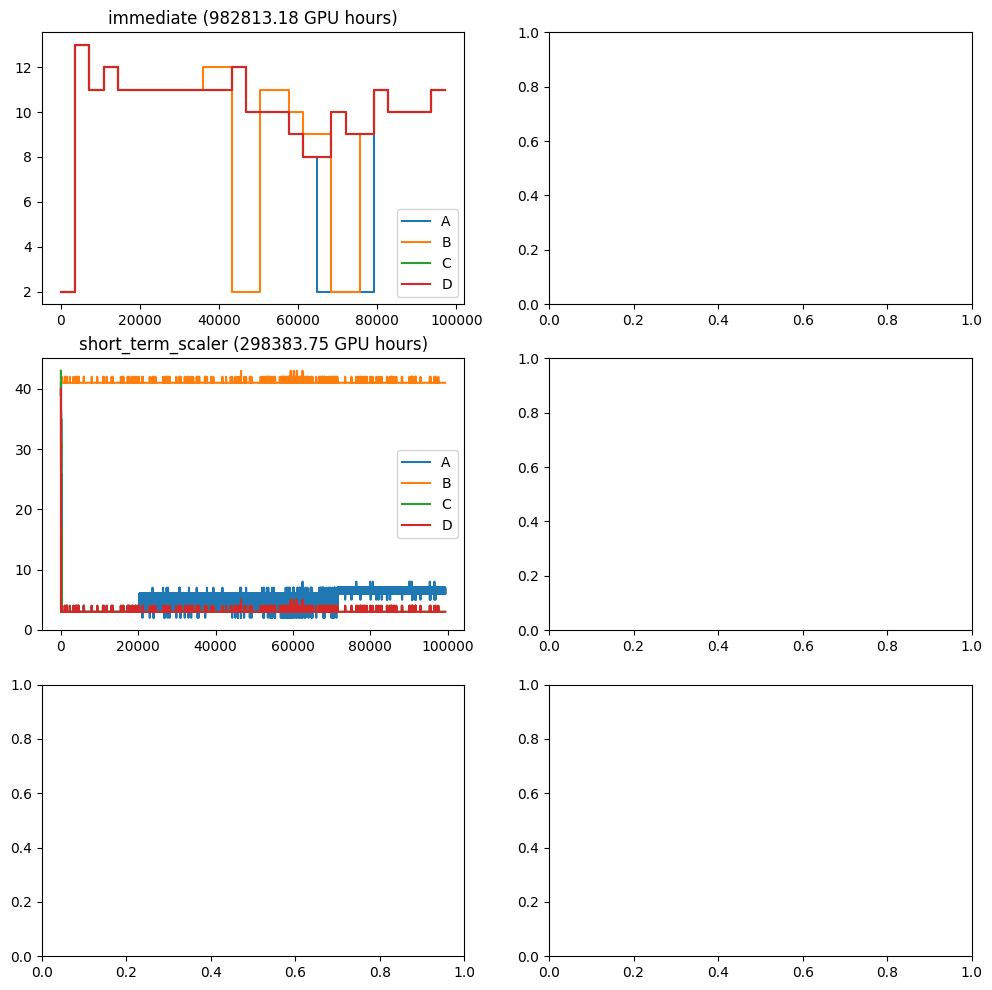

In [35]:
def process_row(row):
    if row["min"] == row["max"]:
        return row["min"] + row["cnt"]
    return row["min"]
fix, ax = plt.subplots(figsize=(12, 12), nrows=3, ncols=2)
i = 0
j = 0
for strategy in paths.keys():
    df = df_instance_counts[strategy]
    for model in ["A", "B", "C", "D"]:
        df_sub = df.loc[df["model"] == model]
        df_sub = df_sub.sort_values(by="timestamp").reset_index()
        df_sub = df_sub.groupby(by=["timestamp"])["prod"].agg([("max", "max"), ("min", "min"), ("cnt", "count")]).reset_index()
        df_sub["final_state"] = df_sub.apply(lambda row: process_row(row), axis=1)
        final_state = []
        for val in df_sub["final_state"]:
            final_state.append(val)
            final_state.append(val)
        final_state = final_state[:-1]
        timestamp = []
        for val in df_sub["timestamp"]:
            timestamp.append(val)
            timestamp.append(val)
        timestamp = timestamp[1:]
        ax[i][j].plot(timestamp, final_state, label=model)
        gpu_hours = 0
        for idx in range(1, len(timestamp)):
            x2 = final_state[idx]
            x1 = final_state[idx - 1]
            y2 = timestamp[idx]
            y1 = timestamp[idx - 1]
            gpu_hours += min(x1, x2) * (y2 - y1) + abs(x2 - x1) * (y2 - y1) / 2
    ax[i][j].set_title(f"{strategy} ({round(gpu_hours, 2)} GPU hours)")
    ax[i][j].legend()
    i += 1
    if i == 3:
        i = 0
        j += 1
plt.show()

In [10]:
df_request_logs["short_term_scaler"].head()

,request_id,model,workload_type,arrival_timestamp,completion_timestamp,global_router_queue_time,region_router_queue_time,model_endpoint_router_queue_time,application_scheduler_queue_time,service_time,application_scheduler_response_time,model_endpoint_router_response_time,region_router_response_time,global_router_response_time,queue_time,region
0,284614,llama2-70b,prod,0.680000,5.375539,1.0,0.0,0.0,0.0,3.695539,3.695539,3.695539,3.695539,4.695539,1.0,centralus
1,289338,bloom-176b,prod,4.296000,6.415796,1.0,0.0,0.0,0.0,1.119796,1.119796,1.119796,1.119796,2.119796,1.0,centralus
2,306154,llama2-70b,prod,5.448000,7.996835,1.0,0.0,0.0,0.0,1.548835,1.548835,1.548835,1.548835,2.548835,1.0,centralus
3,525333,bloom-176b,dev,6.415796,8.093004,1.0,0.0,0.0,0.0,0.677207,0.677207,0.677207,0.677207,1.677207,1.0,centralus
4,286414,bloom-176b,dev,8.093004,9.770211,1.0,0.0,0.0,0.0,0.677207,0.677207,0.677207,0.677207,1.677207,1.0,centralus


In [11]:
average_latencies = []
x_ticks = []
dev_response_count = []
for model in ["bloom-176b", "llama2-70b"]:
    df = df_request_logs[strategy]
    for strategy in paths.keys():
        df_sub = df.loc[df["model"] == model]
        df_sub_prod = df_sub.loc[df_sub["workload_type"] == "prod"]
        df_sub_prod["latency"] = df_sub_prod["completion_timestamp"] - df_sub_prod["arrival_timestamp"]
        average_latencies.append(df_sub_prod["latency"].mean())
        x_ticks.append(f"{strategy}_{model}_prod")
for model in ["bloom-176b", "llama2-70b"]:
    df = df_request_logs[strategy]
    for strategy in paths.keys():
        df_sub = df.loc[df["model"] == model]
        df_sub_dev = df_sub.loc[df_sub["workload_type"] == "dev"]
        df_sub_dev["latency"] = df_sub_dev["completion_timestamp"] - df_sub_dev["arrival_timestamp"]
        average_latencies.append(df_sub_dev["latency"].mean())
        x_ticks.append(f"{strategy}_{model}_dev")
        dev_response_count.append((len(df_sub_dev), strategy, model))

/tmp/ipykernel_906943/4177926182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_prod["latency"] = df_sub_prod["completion_timestamp"] - df_sub_prod["arrival_timestamp"]
/tmp/ipykernel_906943/4177926182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_prod["latency"] = df_sub_prod["completion_timestamp"] - df_sub_prod["arrival_timestamp"]
/tmp/ipykernel_906943/4177926182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

/tmp/ipykernel_906943/4177926182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_prod["latency"] = df_sub_prod["completion_timestamp"] - df_sub_prod["arrival_timestamp"]
/tmp/ipykernel_906943/4177926182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_prod["latency"] = df_sub_prod["completion_timestamp"] - df_sub_prod["arrival_timestamp"]
/tmp/ipykernel_906943/4177926182.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [12]:
dev_response_count

[(1043, 'immediate', 'bloom-176b'),
 (1043, 'delay_changes', 'bloom-176b'),
 (1043, 'keep_maximum_instances', 'bloom-176b'),
 (1043, 'keep_minimum_instances', 'bloom-176b'),
 (1043, 'short_term_scaler', 'bloom-176b'),
 (226914, 'immediate', 'llama2-70b'),
 (226914, 'delay_changes', 'llama2-70b'),
 (226914, 'keep_maximum_instances', 'llama2-70b'),
 (226914, 'keep_minimum_instances', 'llama2-70b'),
 (226914, 'short_term_scaler', 'llama2-70b')]

In [13]:
dev_response_count = sorted(dev_response_count, key=lambda x: x[1])

In [14]:
dev_response_count

[(1043, 'delay_changes', 'bloom-176b'),
 (226914, 'delay_changes', 'llama2-70b'),
 (1043, 'immediate', 'bloom-176b'),
 (226914, 'immediate', 'llama2-70b'),
 (1043, 'keep_maximum_instances', 'bloom-176b'),
 (226914, 'keep_maximum_instances', 'llama2-70b'),
 (1043, 'keep_minimum_instances', 'bloom-176b'),
 (226914, 'keep_minimum_instances', 'llama2-70b'),
 (1043, 'short_term_scaler', 'bloom-176b'),
 (226914, 'short_term_scaler', 'llama2-70b')]

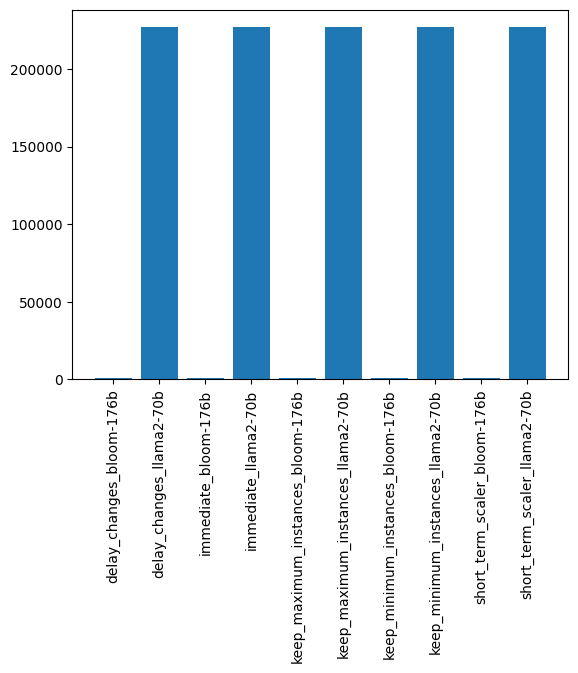

In [15]:
plt.bar([f"{val[1]}_{val[2]}" for val in dev_response_count], [val[0] for val in dev_response_count])
plt.xticks(rotation=90)
plt.show()

In [16]:
average_latencies, x_ticks

([4.797288154451597,
  4.797288154451597,
  4.797288154451597,
  4.797288154451597,
  4.797288154451597,
  18.355026172685015,
  18.355026172685015,
  18.355026172685015,
  18.355026172685015,
  18.355026172685015,
  18.597146896598247,
  18.597146896598247,
  18.597146896598247,
  18.597146896598247,
  18.597146896598247,
  23.621848358603035,
  23.621848358603035,
  23.621848358603035,
  23.621848358603035,
  23.621848358603035],
 ['immediate_bloom-176b_prod',
  'delay_changes_bloom-176b_prod',
  'keep_maximum_instances_bloom-176b_prod',
  'keep_minimum_instances_bloom-176b_prod',
  'short_term_scaler_bloom-176b_prod',
  'immediate_llama2-70b_prod',
  'delay_changes_llama2-70b_prod',
  'keep_maximum_instances_llama2-70b_prod',
  'keep_minimum_instances_llama2-70b_prod',
  'short_term_scaler_llama2-70b_prod',
  'immediate_bloom-176b_dev',
  'delay_changes_bloom-176b_dev',
  'keep_maximum_instances_bloom-176b_dev',
  'keep_minimum_instances_bloom-176b_dev',
  'short_term_scaler_bloom-1

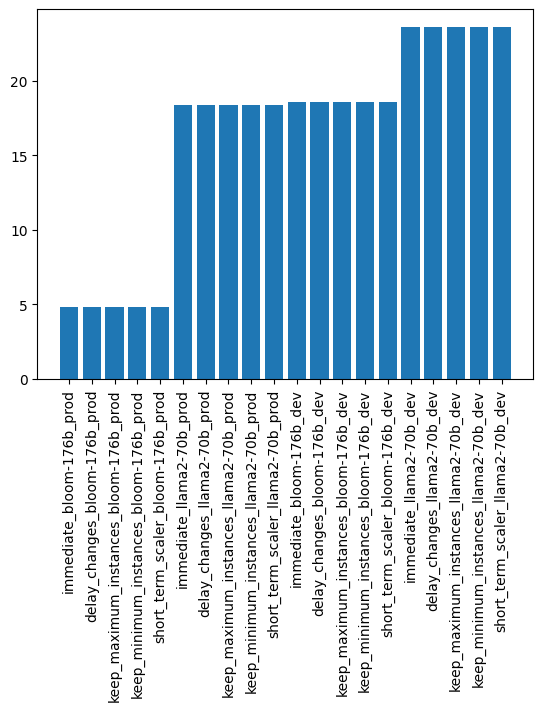

In [17]:
latencies_list = []
latencies_name = []
for i in range(len(average_latencies)):
    latencies_list.append(average_latencies[i])
    latencies_name.append(x_ticks[i])
plt.bar(x_ticks, average_latencies)
plt.xticks(rotation=90)
plt.show()

In [5]:
requests = pd.read_csv("../traces/ES_26.csv")

def idk(idx):
    try:
        return requests.loc[requests["request_id"] == idx].iloc[0]["workload_type"]
    except:
        print("not found", idx)
        return "prod"

for key, p in paths.items():
    dfs = []
    for m in ["bloom-176b", "llama2-70b"]:
        dataframes = []
        for r in ["centralus", "eastus", "westus"]:
            df = pd.concat([pd.read_csv(f"{p}/detailed/{r}_{m}_{i}.csv") for i in range(14)])
            dataframes.append(df)
        df = pd.concat(dataframes)
        del dataframes
        # df = df.sort_values(by="request_ids").reset_index()
        dfs.append(df)
    df = pd.concat(dfs)
    df = df.sort_values(by="request_ids").reset_index()
    df["workload_type"] = df.apply(lambda row: idk(row["request_ids"]), axis=1)
    df_prod = df.loc[df["workload_type"] == "prod"]
    df_dev = df.loc[df["workload_type"] == "dev"]
    print(len(df_prod), df_prod["ttft_times"].mean(), df_prod["tbt_times"].mean())
    print(len(df_dev), df_dev["ttft_times"].mean(), df_dev["tbt_times"].mean())

264964 4.3495269558144 0.11203277283988361
206707 5.00337005254751 0.13647444205703044
256860 4.394788580951759 0.11350758608994299
208564 5.131790852355843 0.13934197149165453
273459 4.144619949408194 0.09526642493414407
213339 5.208360212779385 0.13974991848508525
228788 4.333988416729511 0.1129701440509805
186886 5.346978425999358 0.14012785443878273
282031 3.5554539624902195 0.072520953456693
221188 3.9498616409037717 0.11745732547550751
